In [1]:
#import all libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import zscore

In [2]:
df = pd.read_csv('../data/train.csv')
df.columns = df.columns.str.strip()

# 2️⃣ Clean all string/object columns: strip spaces, replace blanks with NaN
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].replace({'': np.nan, 'nan': np.nan, 'NaN': np.nan})

# 3️⃣ Normalize Yes/No columns to consistent "Yes"/"No"
yes_no_cols = ['CrossBorder_Shipping', 'Urgent_Shipping', 'Installation_Service',
               'Fragile_Equipment', 'Rural_Hospital']
for col in yes_no_cols:
    if col in df.columns:
        df[col] = df[col].replace({
            'YES': 'Yes', 'yes': 'Yes', 'Y': 'Yes', 'y': 'Yes',
            'NO': 'No', 'no': 'No', 'N': 'No', 'n': 'No'
        })

# 4️⃣ Convert date columns to datetime
df['Order_Placed_Date'] = pd.to_datetime(df['Order_Placed_Date'], errors='coerce')
df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'], errors='coerce')

# 5️⃣ Create new feature: Delivery_Days (difference in days)
df['Delivery_Days'] = (df['Delivery_Date'] - df['Order_Placed_Date']).dt.days
df['Delivery_Days'] = pd.to_numeric(df['Delivery_Days'], errors='coerce')

# delete initial date rows
# df = df.dropna(subset=['Order_Placed_Date', 'Delivery_Date'])

# 7️⃣ Drop exact duplicate rows
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"Dropped {before - after} duplicate rows.")

# 8️⃣ Quick check after cleaning
print("After basic cleaning shape:", df.shape)
print("\nMissing values after cleaning:")
print(df.isna().sum())
df.head()


C:\Users\Ayush Mishra\AppData\Local\Temp\ipykernel_12100\3693676419.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Order_Placed_Date'] = pd.to_datetime(df['Order_Placed_Date'], errors='coerce')
C:\Users\Ayush Mishra\AppData\Local\Temp\ipykernel_12100\3693676419.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'], errors='coerce')


Dropped 0 duplicate rows.
After basic cleaning shape: (5000, 21)

Missing values after cleaning:
Hospital_Id                0
Supplier_Name              0
Supplier_Reliability     587
Equipment_Height         283
Equipment_Width          443
Equipment_Weight         460
Equipment_Type           599
Equipment_Value            0
Base_Transport_Fee         0
CrossBorder_Shipping       0
Urgent_Shipping            0
Installation_Service       0
Transport_Method        1071
Fragile_Equipment          0
Hospital_Info              0
Rural_Hospital           586
Order_Placed_Date          0
Delivery_Date              0
Hospital_Location          0
Transport_Cost             0
Delivery_Days              0
dtype: int64


,Hospital_Id,Supplier_Name,Supplier_Reliability,Equipment_Height,Equipment_Width,Equipment_Weight,Equipment_Type,Equipment_Value,Base_Transport_Fee,CrossBorder_Shipping,...,Installation_Service,Transport_Method,Fragile_Equipment,Hospital_Info,Rural_Hospital,Order_Placed_Date,Delivery_Date,Hospital_Location,Transport_Cost,Delivery_Days
0,fffe3200360030003700,Jo Valencia,0.44,21.0,6.0,NaN,NaN,3.62,17.13,No,...,No,Roadways,No,Working Class,No,2017-10-20,2017-10-20,APO AA 33776,179.50,0
1,fffe3400380037003400,Wanda Warren,0.58,29.0,20.0,1210684.0,Marble,9703.37,35.42,No,...,Yes,Roadways,No,Working Class,No,2016-02-22,2016-02-24,"South Kevin, VT 84493",627732.45,2
2,fffe3200350036003700,Robert Ackies,0.97,39.0,15.0,3305.0,Aluminium,40.21,18.54,No,...,No,Roadways,No,Working Class,No,2018-01-11,2018-01-10,"Kevinshire, NE 31279",1565.92,-1
3,fffe3800320034003400,Charlotte Membreno,0.70,8.0,5.0,606.0,Brass,4.55,17.48,No,...,No,Roadways,No,Working Class,No,2016-08-06,2016-08-06,DPO AP 61572,257.71,0
4,fffe3600340033003000,Nena Silva,0.66,27.0,13.0,NaN,Marble,2726.80,30.23,Yes,...,No,Roadways,No,Working Class,NaN,2016-12-15,2016-12-17,"Joshuamouth, AK 01550",8553.52,2


===== BASIC NUMERIC STATISTICS =====


,count,mean,std,min,25%,50%,75%,max
Supplier_Reliability,4413.0,0.460925,2.659637e-01,0.0,0.23,0.450,0.6700,1.000000e+00
Equipment_Height,4717.0,21.759593,1.194443e+01,3.0,12.00,20.000,30.0000,7.300000e+01
Equipment_Width,4557.0,9.585034,5.407542e+00,2.0,6.00,8.000,12.0000,5.000000e+01
Equipment_Weight,4540.0,409758.435022,2.808640e+06,3.0,507.00,3137.500,36941.5000,1.179279e+08
Equipment_Value,5000.0,1190.293363,8.724804e+03,3.0,5.26,7.935,87.0475,3.823857e+05
Base_Transport_Fee,5000.0,37.374362,2.690791e+01,10.0,16.63,23.410,57.8050,9.998000e+01
Delivery_Days,5000.0,-0.020000,2.430469e+00,-4.0,-2.00,0.000,2.0000,4.000000e+00



===== SKEWNESS =====


Supplier_Reliability     0.144288
Equipment_Height         0.580025
Equipment_Width          1.595053
Equipment_Weight        22.595816
Equipment_Value         24.093047
Base_Transport_Fee       0.920960
Delivery_Days           -0.006553
dtype: float64

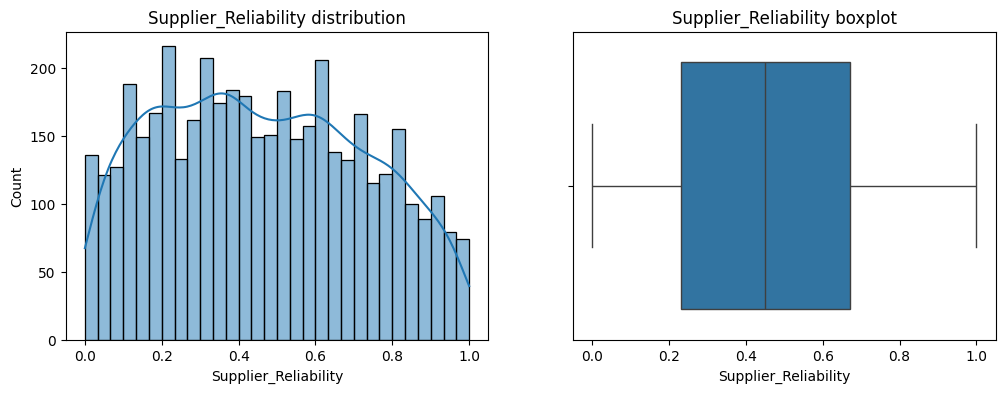

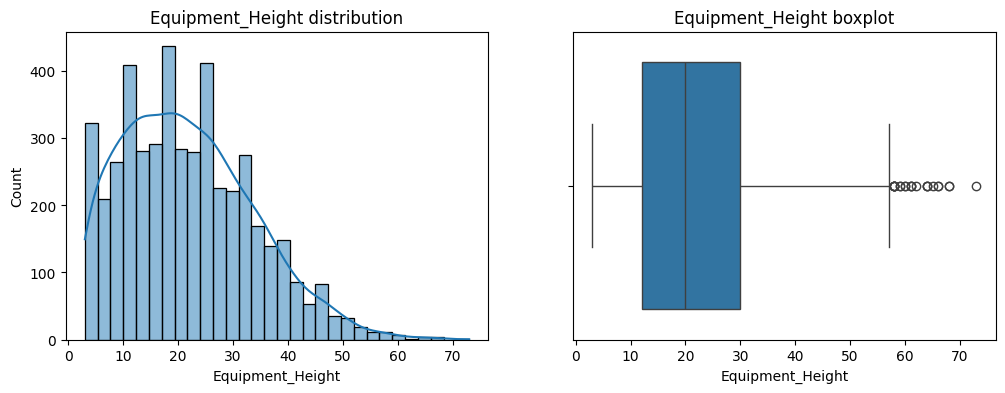

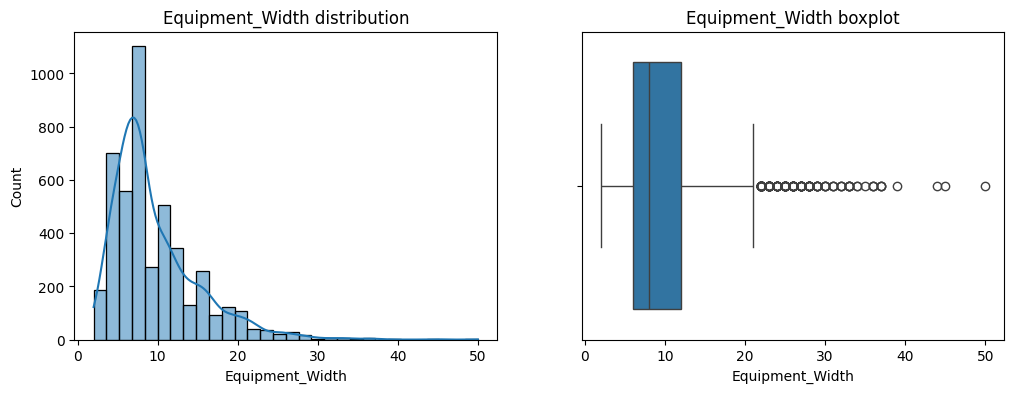

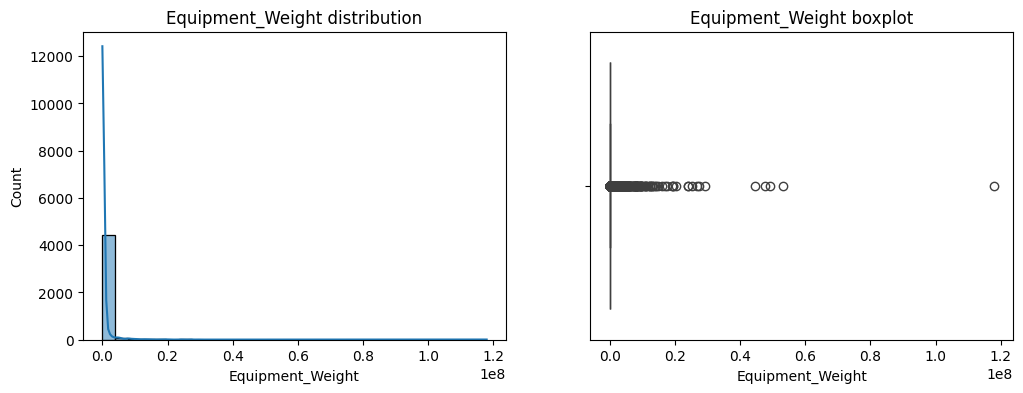

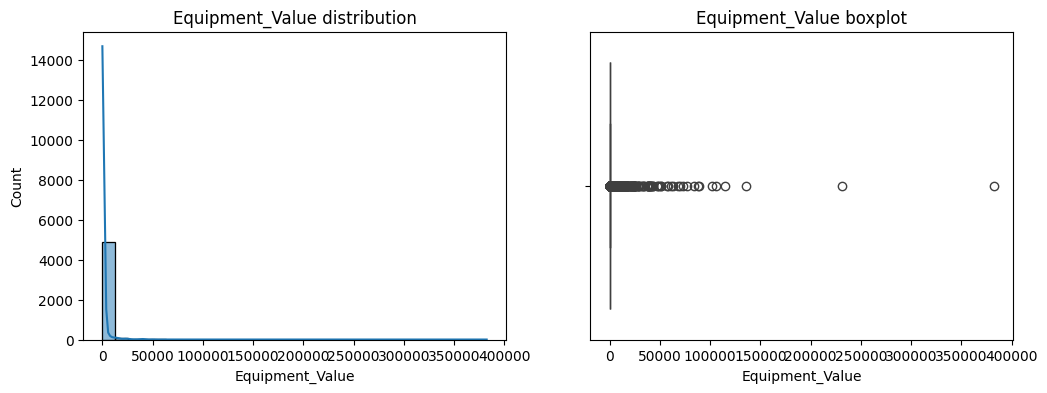

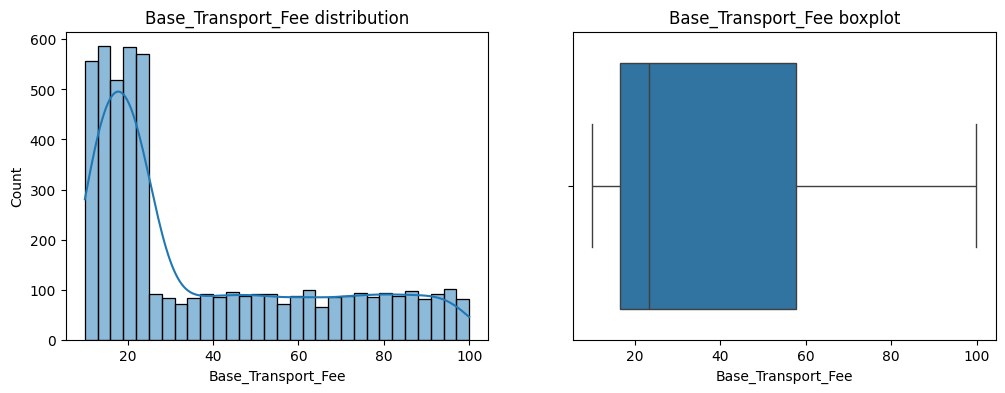

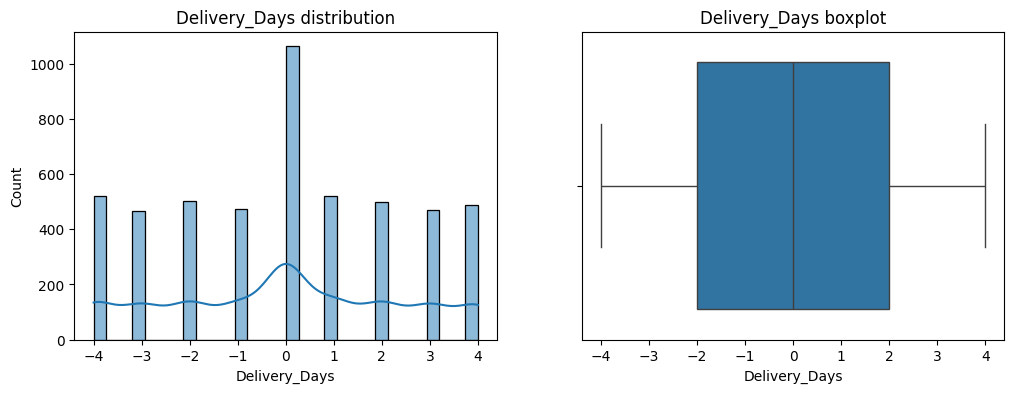

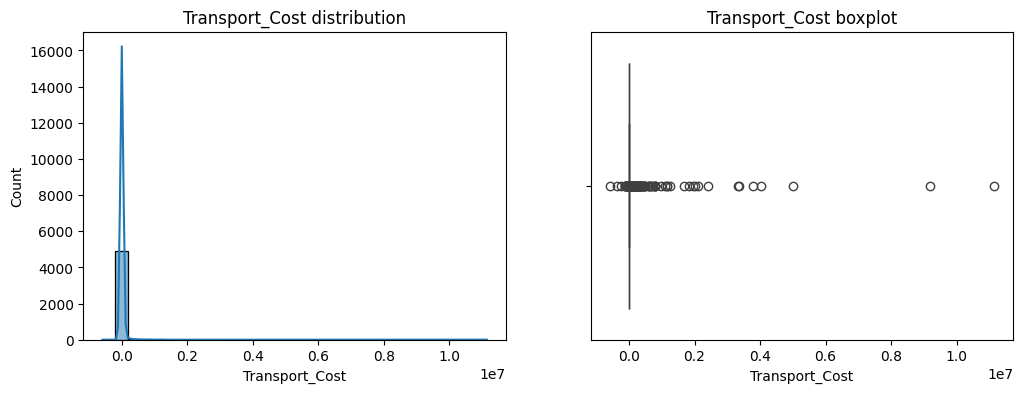

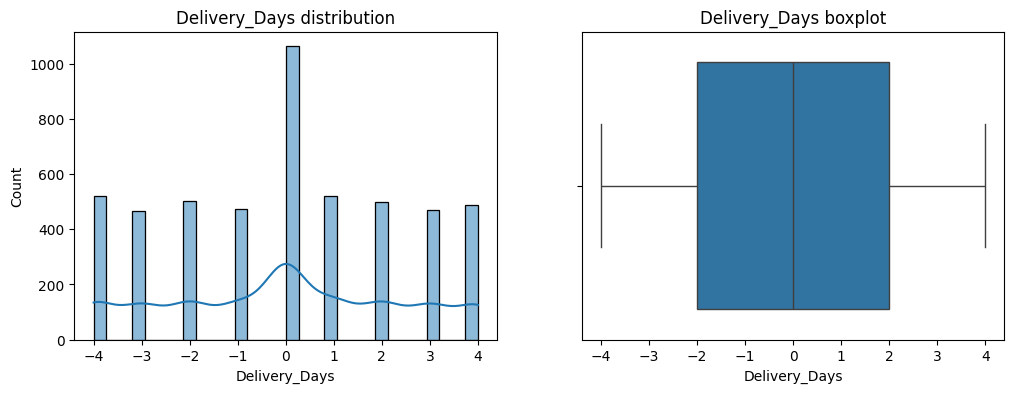

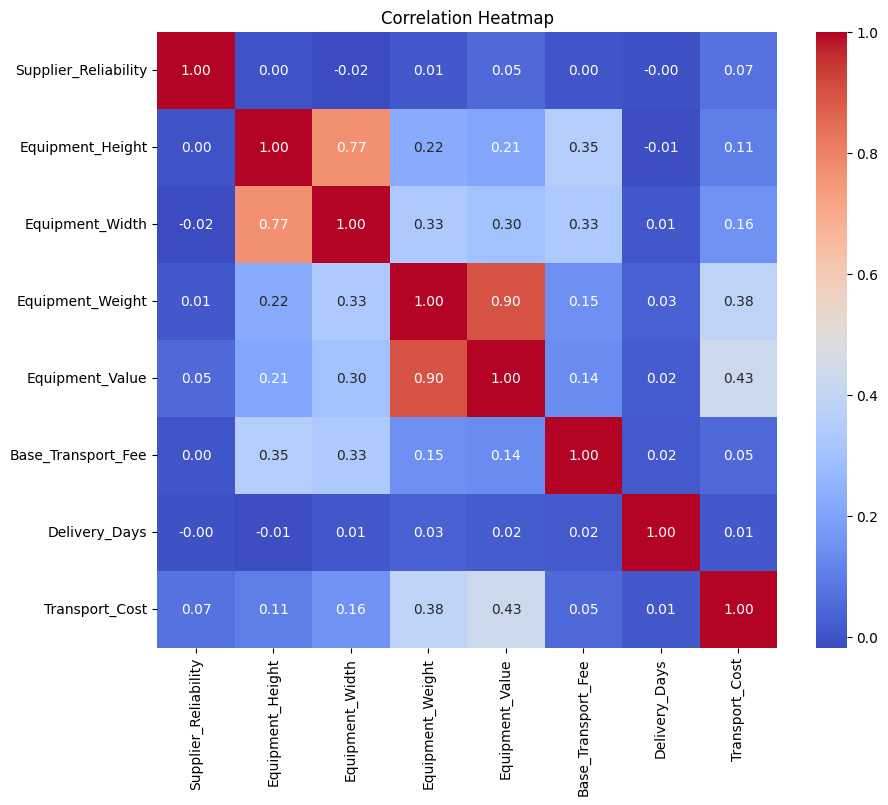


===== Column: Hospital_Id =====
Hospital_Id
fffe3200360030003700    1
fffe3400380037003400    1
fffe3200350036003700    1
fffe3800320034003400    1
fffe3600340033003000    1
                       ..
fffe3800360039003100    1
fffe3900320037003800    1
fffe380034003700        1
fffe3600310031003200    1
fffe3100300038003300    1
Name: count, Length: 5000, dtype: int64


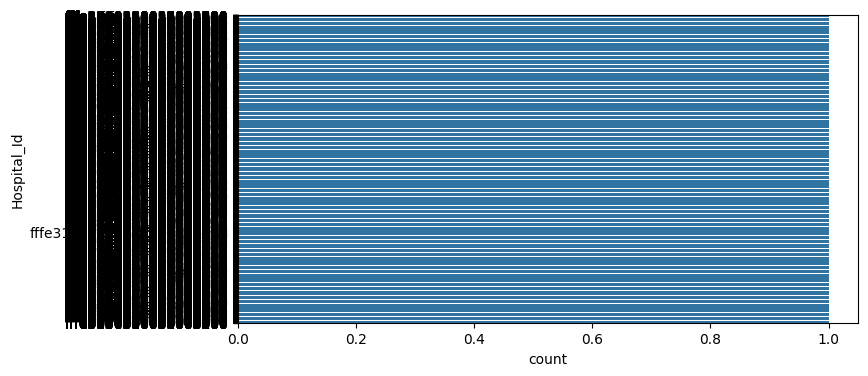


===== Column: Supplier_Name =====
Supplier_Name
Robert Davis        3
James Moore         3
John Brown          3
James White         3
Walter Patterson    2
                   ..
Grace Gazzo         1
Richard Bell        1
Flora Spencer       1
Rena Best           1
Jacob Buckley       1
Name: count, Length: 4966, dtype: int64


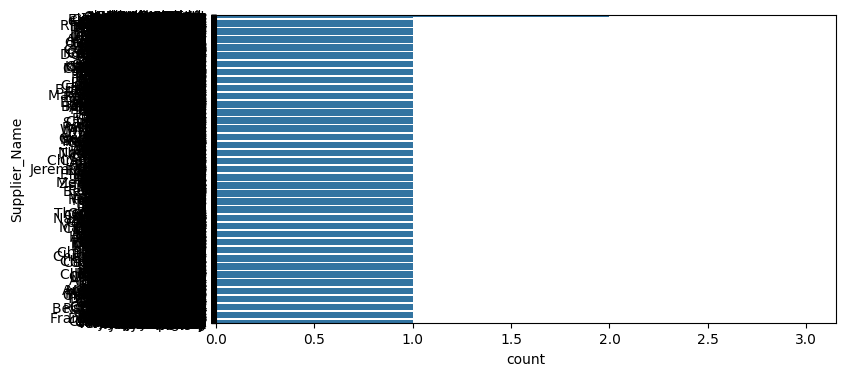


===== Column: Equipment_Type =====
Equipment_Type
Aluminium    655
Bronze       648
Brass        625
Marble       624
Clay         624
Wood         619
Stone        606
NaN          599
Name: count, dtype: int64


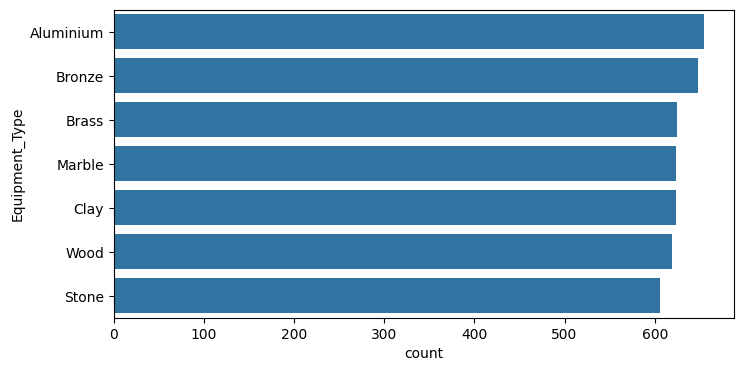


===== Column: CrossBorder_Shipping =====
CrossBorder_Shipping
No     3333
Yes    1667
Name: count, dtype: int64


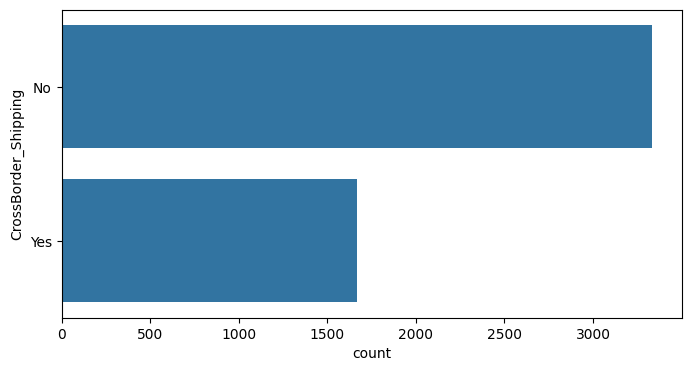


===== Column: Urgent_Shipping =====
Urgent_Shipping
No     3351
Yes    1649
Name: count, dtype: int64


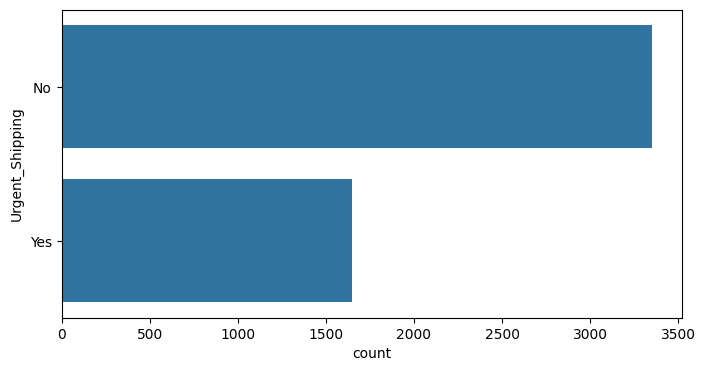


===== Column: Installation_Service =====
Installation_Service
No     2998
Yes    2002
Name: count, dtype: int64


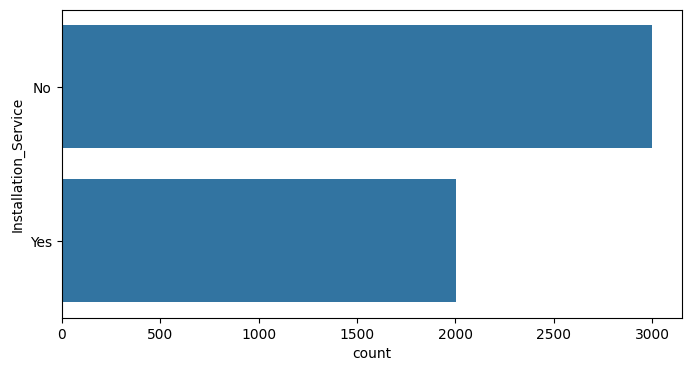


===== Column: Transport_Method =====
Transport_Method
Roadways     1604
Airways      1364
NaN          1071
Waterways     961
Name: count, dtype: int64


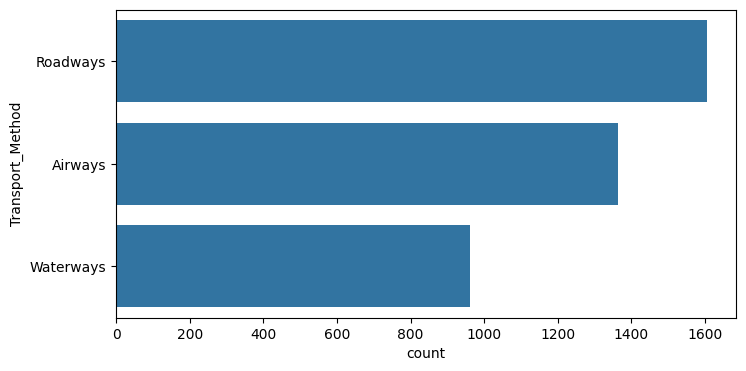


===== Column: Fragile_Equipment =====
Fragile_Equipment
No     4201
Yes     799
Name: count, dtype: int64


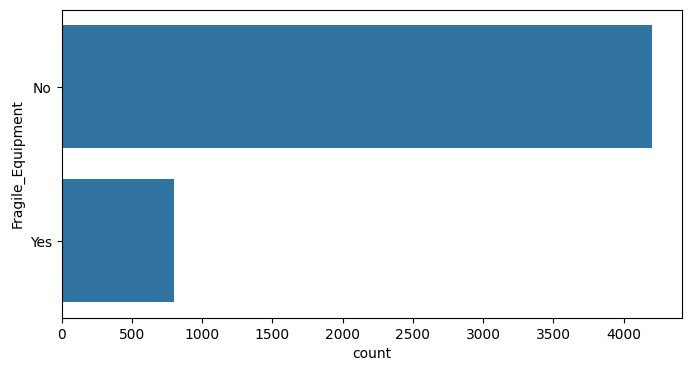


===== Column: Hospital_Info =====
Hospital_Info
Working Class    3672
Wealthy          1328
Name: count, dtype: int64


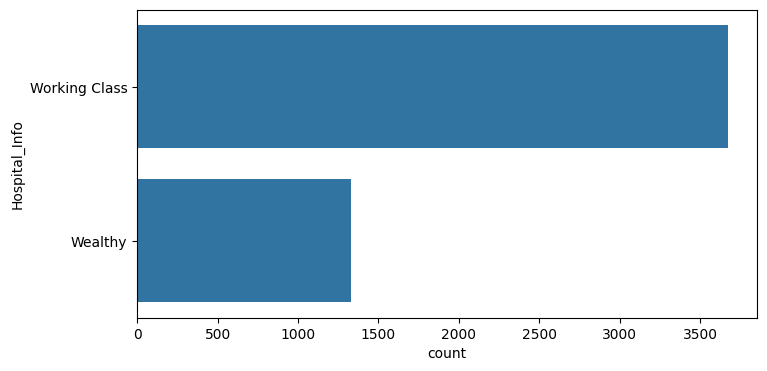


===== Column: Rural_Hospital =====
Rural_Hospital
No     3527
Yes     887
NaN     586
Name: count, dtype: int64


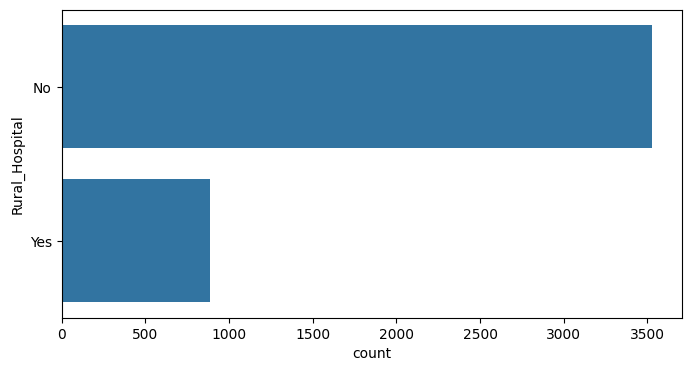


===== Column: Hospital_Location =====
Hospital_Location
APO AA 33776             1
South Kevin, VT 84493    1
Kevinshire, NE 31279     1
DPO AP 61572             1
Joshuamouth, AK 01550    1
                        ..
APO AP 84078             1
Michaelland, ID 05476    1
Danielshire, WY 95397    1
Sherrybury, VA 40745     1
DPO AE 88710             1
Name: count, Length: 5000, dtype: int64


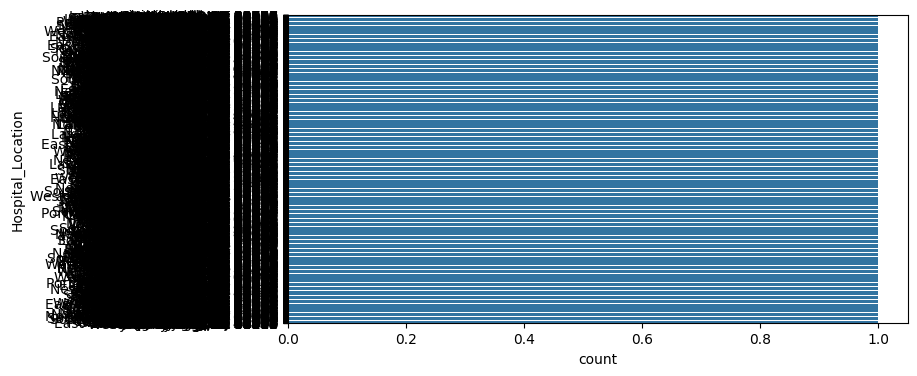

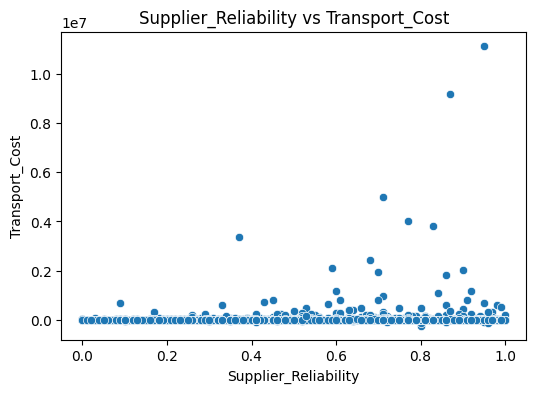

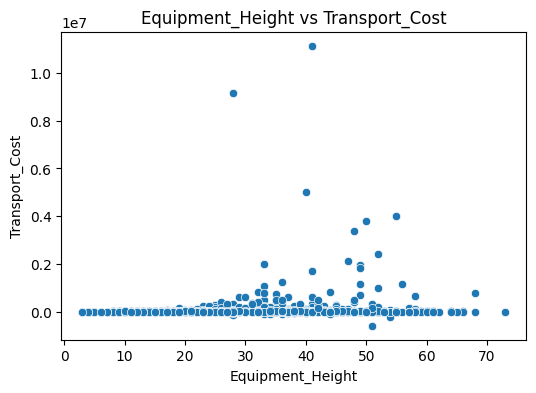

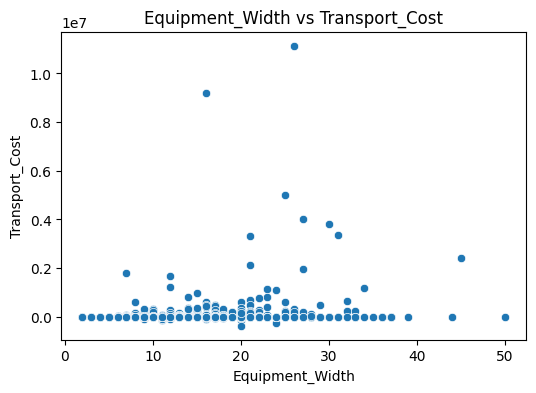

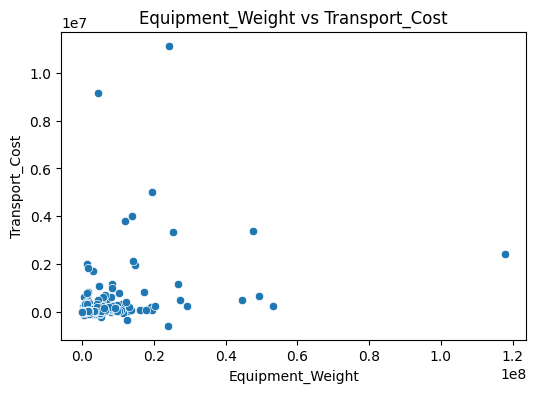

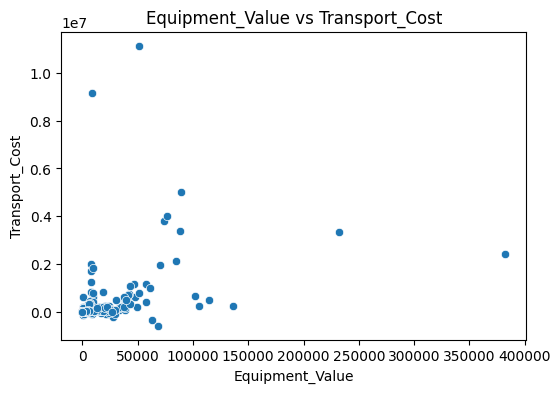

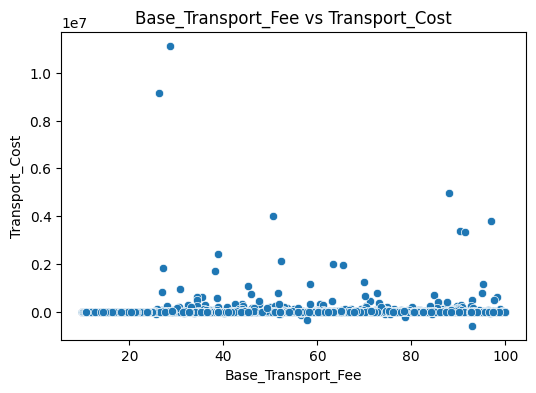

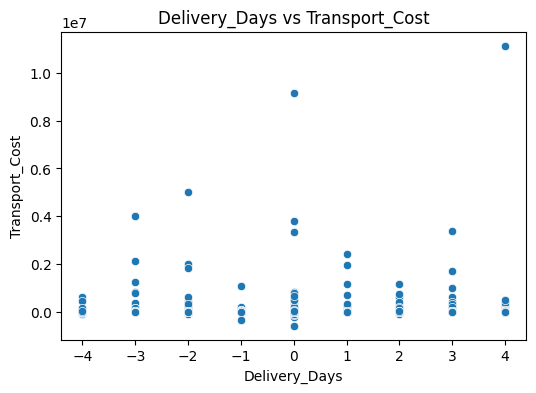

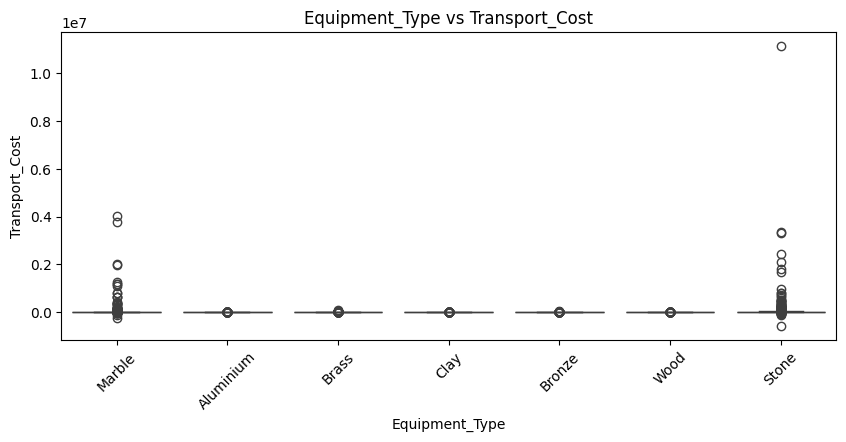

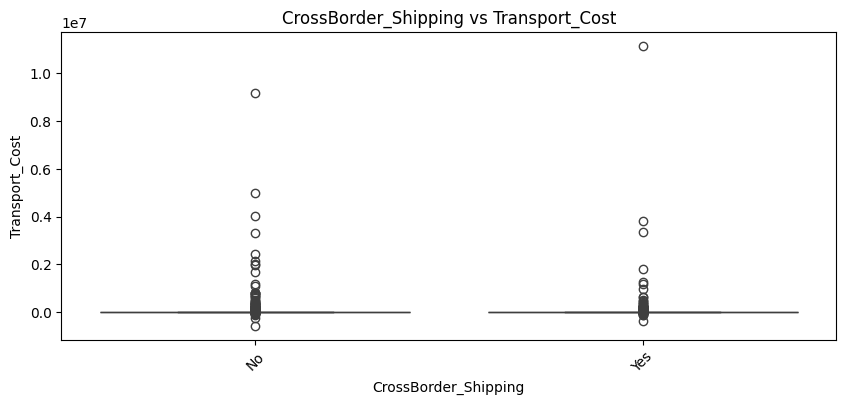

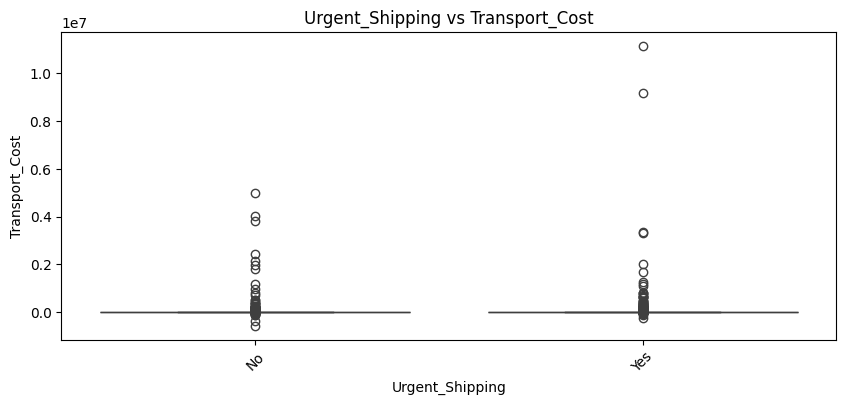

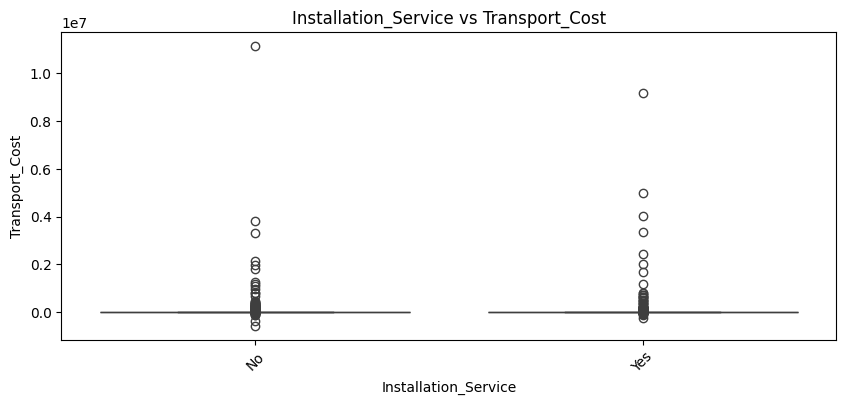

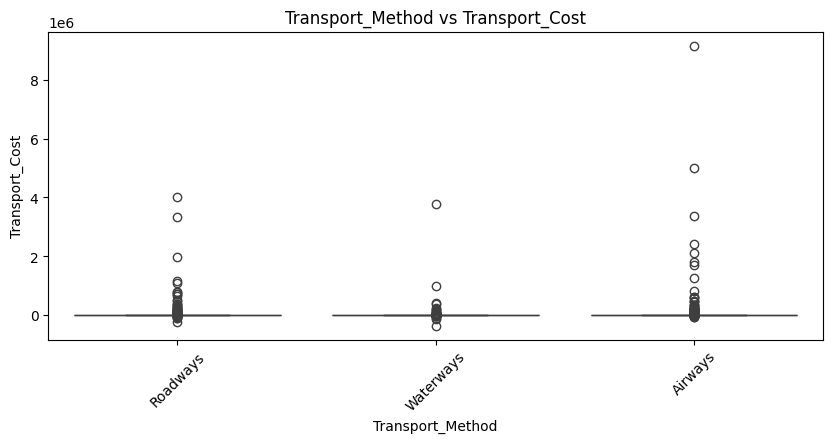

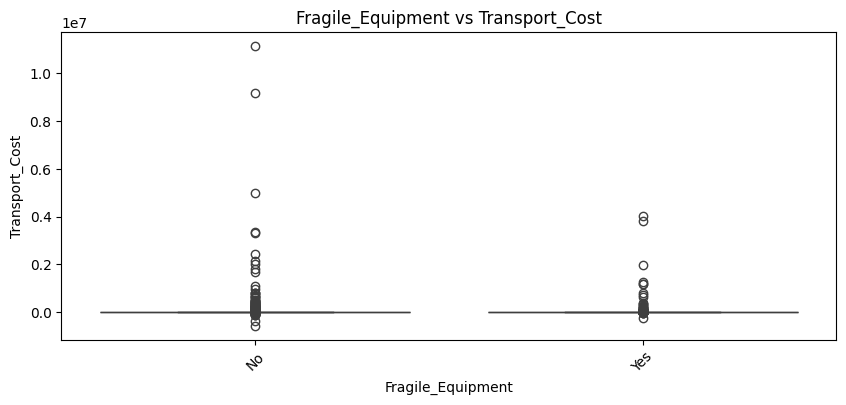

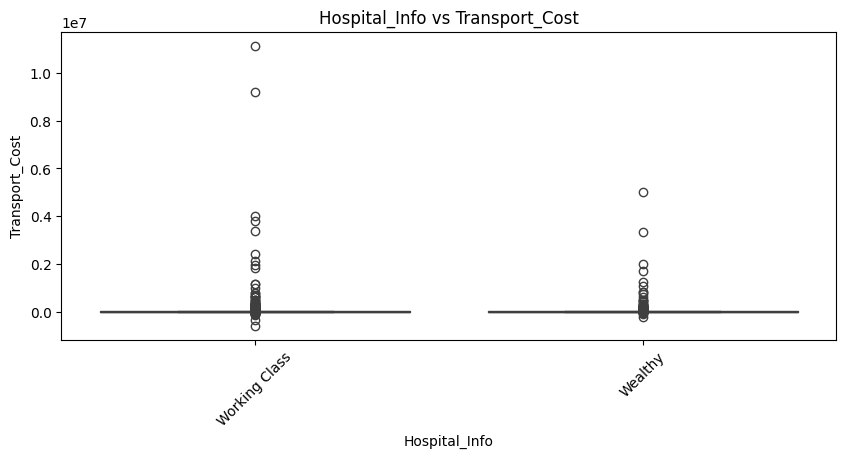

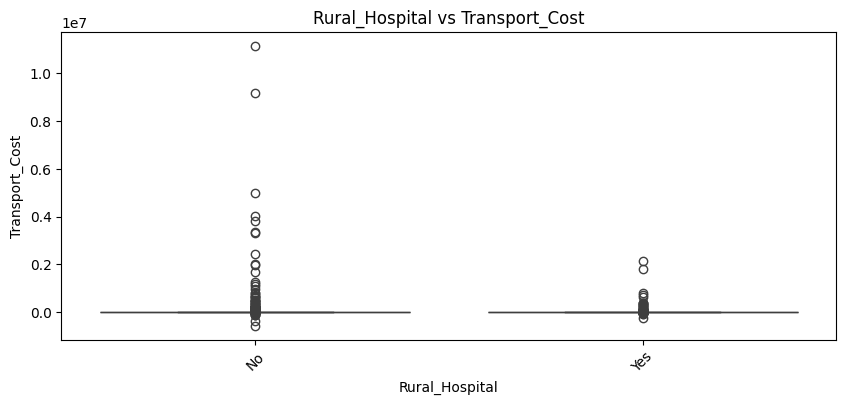


===== NUMBER OF OUTLIERS PER COLUMN (Z-score > 3) =====
Supplier_Reliability     0
Equipment_Height         0
Equipment_Width          0
Equipment_Weight         0
Equipment_Value         47
Base_Transport_Fee       0
Delivery_Days            0
Transport_Cost          22
dtype: int64


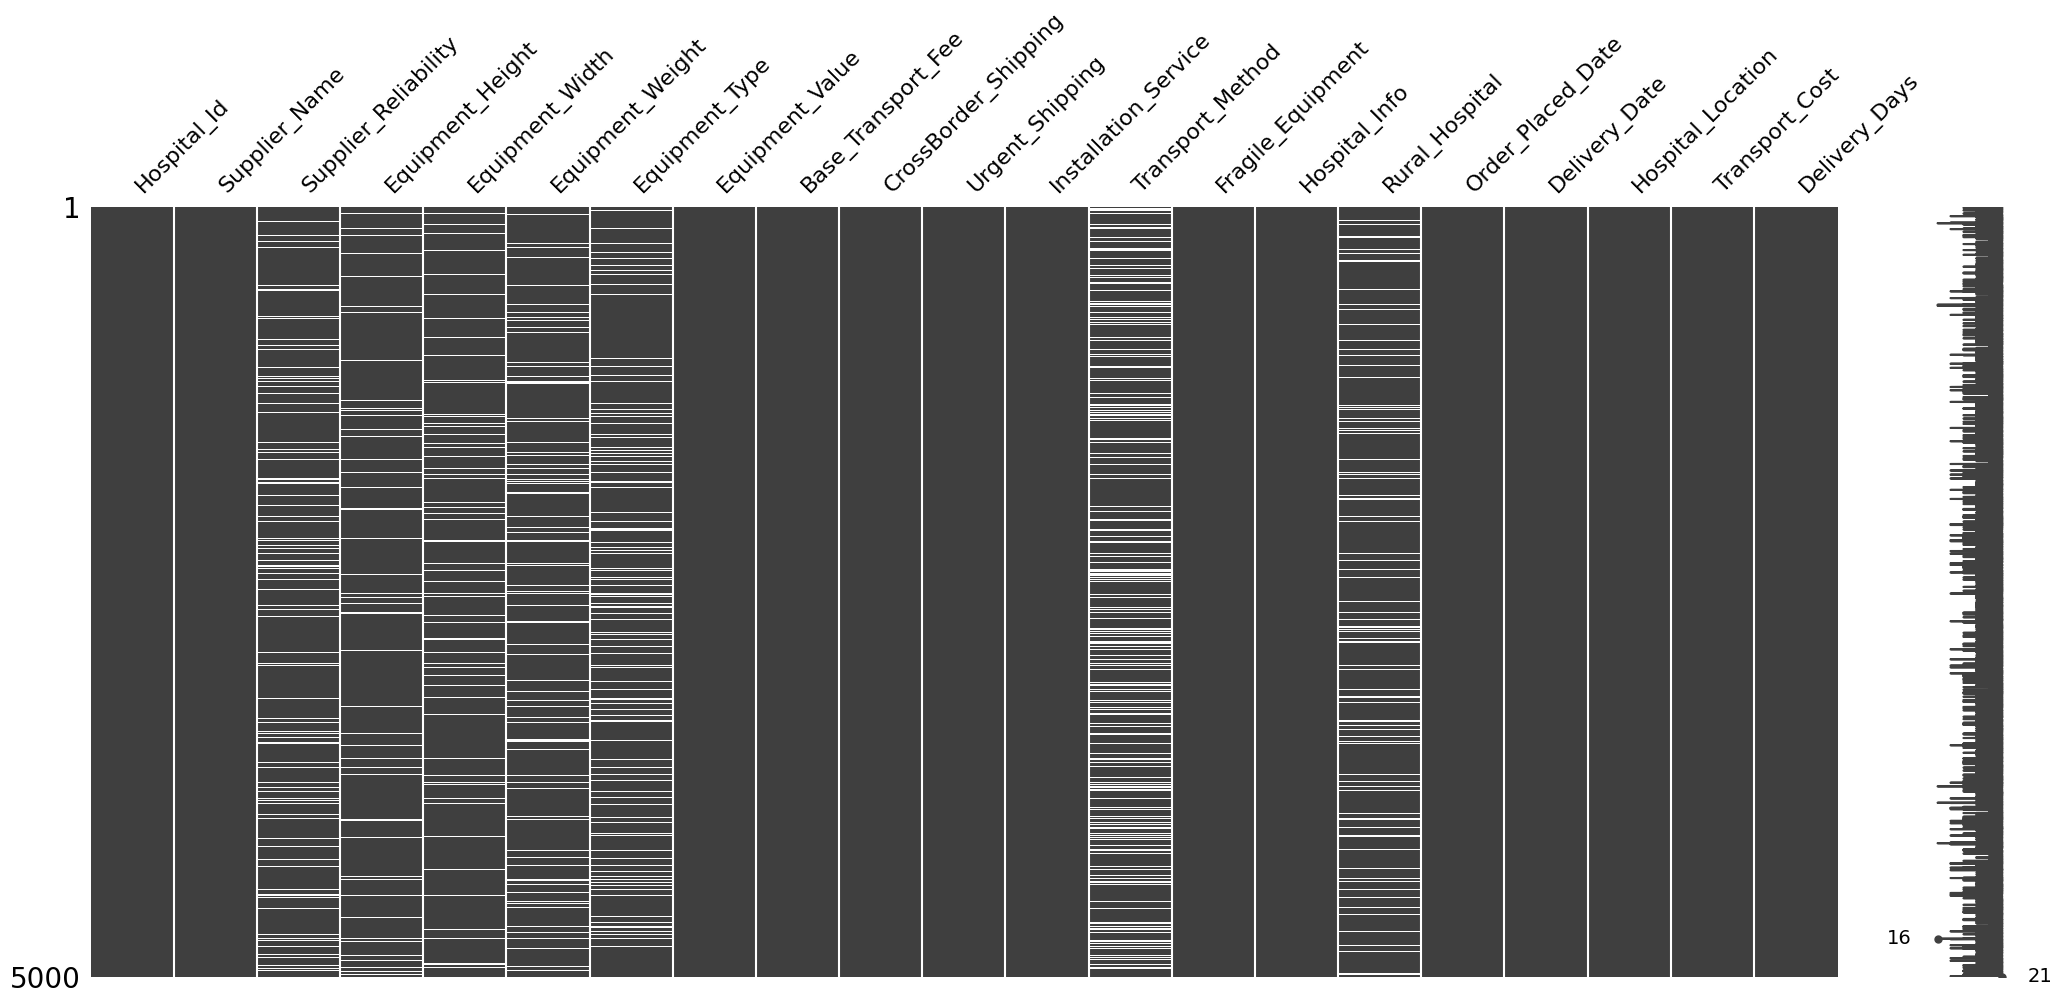

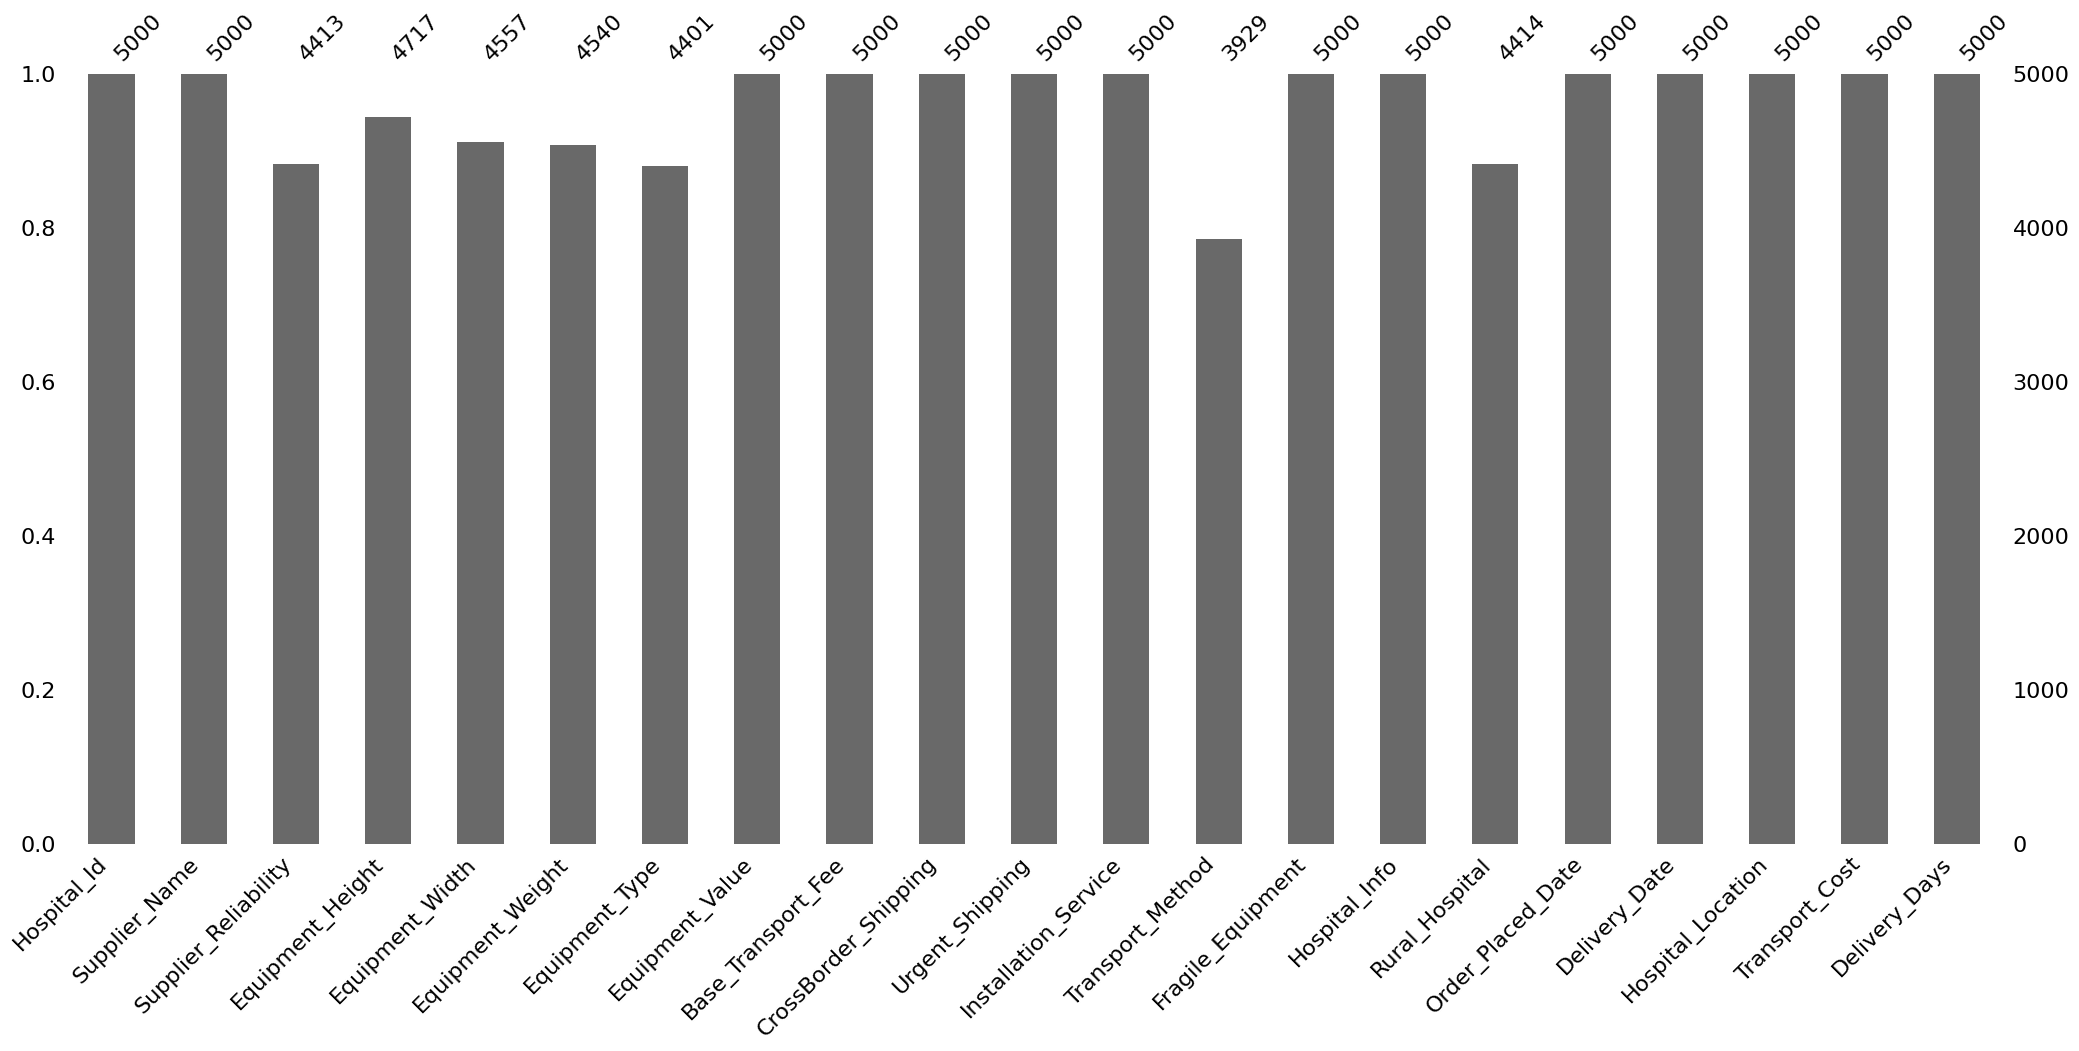

In [3]:


num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols.remove('Transport_Cost')  # target handled separately
cat_cols = df.select_dtypes(include='object').columns.tolist()

# value/weight

print("===== BASIC NUMERIC STATISTICS =====")
display(df[num_cols].describe().T)

print("\n===== SKEWNESS =====")
display(df[num_cols].skew())

# 🔹 Numeric distributions + boxplots
for col in num_cols + ['Transport_Cost', 'Delivery_Days']:
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'{col} distribution')
    
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col])
    plt.title(f'{col} boxplot')
    
    plt.show()

# 🔹 Correlation heatmap
plt.figure(figsize=(10,8))
corr = df[num_cols + ['Transport_Cost']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# 🔹 Categorical distributions
for col in cat_cols:
    print(f"\n===== Column: {col} =====")
    print(df[col].value_counts(dropna=False))
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.show()

# 🔹 Numeric features vs target
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[col], y=df['Transport_Cost'])
    plt.title(f'{col} vs Transport_Cost')
    plt.show()

# 🔹 Categorical features vs target (only low-cardinality)
for col in cat_cols:
    if df[col].nunique() < 20:
        plt.figure(figsize=(10,4))
        sns.boxplot(x=col, y='Transport_Cost', data=df)
        plt.title(f'{col} vs Transport_Cost')
        plt.xticks(rotation=45)
        plt.show()

# 🔹 Outlier detection (Z-score)
z_scores = df[num_cols + ['Transport_Cost']].apply(zscore)
outliers = (abs(z_scores) > 3).sum()
print("\n===== NUMBER OF OUTLIERS PER COLUMN (Z-score > 3) =====")
print(outliers)

# 🔹 Missing value visualization
msno.matrix(df)
plt.show()
msno.bar(df)
plt.show()